In [41]:
import random
from geoarray import GeoArray
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.signal import savgol_filter
from scipy.interpolate import splev, splrep

In [42]:
# importing ISOFIT
from isofit.utils import surface_model
from isofit.core.forward import ForwardModel
from isofit.configs.configs import create_new_config
from isofit.inversion.inverse import Inversion
from isofit.core.fileio import IO

In [43]:
import tkinter
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

In [44]:
cluster_1 = np.loadtxt(r'C:\Users\vpatro\Desktop\Final_Spectra\425\Cl_1.txt')

In [55]:
cluster_1.shape

(568528, 425)

In [56]:
def sample_spectra(cluster_spectra:np.array):

    sample_sets = []
    for i in range(5):
        sample = random.sample(range(0, cluster_spectra.shape[0]), 10)
        sample_sets.append(cluster_spectra[sample])
        
    sample_sets = np.array(sample_sets)
        
    return sample_sets

In [57]:
def expand_spectra(cluster_spectra: np.array):
    display = np.empty((cluster_spectra.shape[0], cluster_spectra.shape[1], 425))
    display[:] = np.nan

    """
    for i in range(cluster_spectra.shape[0]):
        display[i, 3:182] = cluster_spectra[i][0:179]
        display[i, 224:276] = cluster_spectra[i][179:231]
        display[i, 329:419] = cluster_spectra[i][231:321]
        
    """
    
    display[:,:, 3:182] = cluster_spectra[:,:,0:179]
    display[:,:, 224:276] = cluster_spectra[:,:,179:231]
    display[:,:, 329:419] = cluster_spectra[:,:,231:321]
    
    
        
    return display
    

In [64]:
def add_RT_parameters(sample_spectra:np.array)-> np.array:
    
    
    H2O = [1.75] * sample_spectra.shape[0]
    AOT = [0.05] * sample_spectra.shape[0]
    
    H2O = np.array(H2O)[:,None]
    AOT = np.array(AOT)[:,None]
    
    augmented = np.concatenate((sample_spectra, H2O), axis = 1)
    augmented = np.concatenate((augmented, AOT), axis = 1)
    
    return augmented

In [59]:
sample_sets_1 = sample_spectra(cluster_1)

In [60]:
sample_sets_1.shape

(5, 10, 425)

In [61]:
sample_sets_1[0][0].shape

(425,)

In [65]:
augmented_1 = []
for i in range(sample_sets_1.shape[0]):
    augmented = add_RT_parameters(sample_sets_1[i])
    augmented_1.append(augmented)
    

In [121]:
augmented_1[0].shape

(10, 427)

In [70]:
augmented_1[0][0].shape

(427,)

In [117]:
def run_ISOFIT(input_reflectance: np.array) -> np.array:
    
    # Surface model
    surface_model("C:\\Users\\vpatro\\Desktop\\isofit_vp\\examples\\20171108_Pasadena\\configs\\ang20171108t184227_aquatic.json")

    # Creating ISOFIT objects
    config = create_new_config("C:\\Users\\vpatro\\Desktop\\isofit_vp\\examples\\20171108_Pasadena\\configs\\ang20171108t184227_beckmanlawn.json")
    fm = ForwardModel(config)
    inv = Inversion(config, fm)
    io = IO(config, fm)
    io.get_components_at_index(0, 0)
    geom = io.current_input_data.geom # alternately, call via geom = Geometry()...this won't have data from the above config file
    meas = io.current_input_data.meas  # a numpy  array

    # adding in Radiative Transfer Parameters
    #x = np.loadtxt("C:\\Users\\vpatro\\Desktop\\avirisng_input.txt")
    input_reflectance = np.append(input_reflectance,1.75)
    input_reflectance = np.append(input_reflectance,0.05)
    
    radiance_measurement = fm.calc_rdn(input_reflectance,geom)
    OE_estimation = inv.invert(radiance_measurement, geom)[-1]
    
    return OE_estimation

IndexError: index -1 is out of bounds for axis 0 with size 0

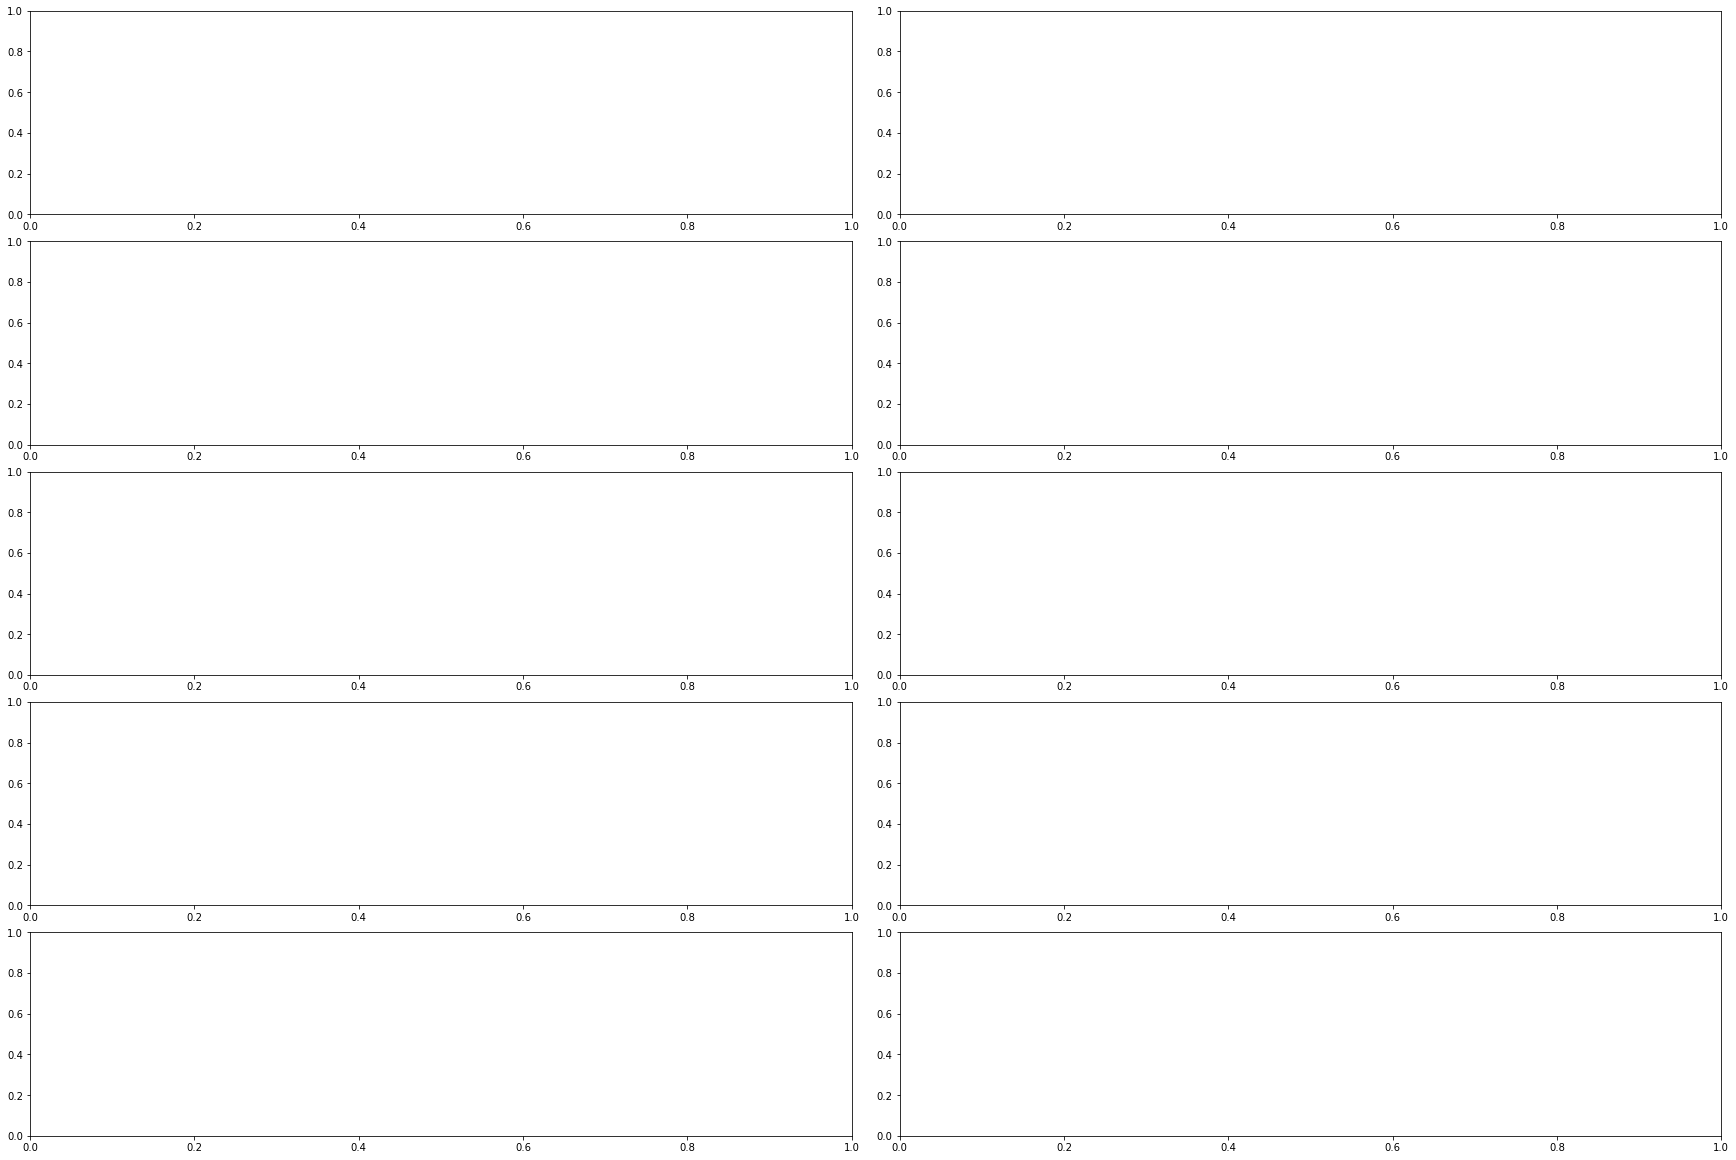

In [ ]:
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (24,16), constrained_layout = True)
l2norms = []
residuals = []
count = 0
row = 0
col = 0
for i in range(10):
    if col == 2:
        row +=1
        col = 0
    input_vec = augmented_1[0][i]
    OE_estimation = run_ISOFIT(input_vec)
    l2norm = np.linalg.norm(input_vec - OE_estimation)
    l2norms.append(l2norm)
    residual = input_vec-OE_estimation
    residuals.append(residual)
    axs[row,col].plot(input_vec[:425], label = 'input')
    axs[row,col].plot(OE_estimation[:425], label = 'output')
    axs[row,col].legend()
    axs[row,col].set_ylim(0,0.3)
    col+= 1



In [102]:
residuals = np.array(residuals)
print(residuals.shape)

(10, 427)


In [103]:
res_cov = residuals[:,:425].copy()

In [104]:
res_cov.shape

(10, 425)

Text(0.5, 1.0, 'Covariance of data')

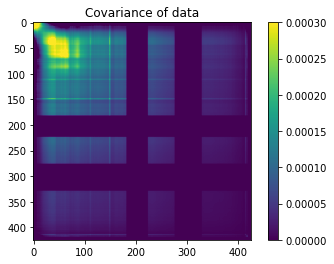

In [110]:
bands = list(range(0,425))
bands = np.array(bands)
deeph2o = np.logical_or(np.logical_and(bands > 181, bands < 224), np.logical_and(bands > 275, bands < 329))
bad_cal = bands > 418
bad = np.logical_or(deeph2o, bad_cal)
res_cov[:, bad] = 0

Cov = np.cov(res_cov, rowvar=False)

plt.imshow(Cov)
plt.colorbar()
plt.clim(0,0.0003)
plt.title('Covariance of data')